## Feature Selection



#### Outlier removal using Z-score method

In [59]:

from scipy import stats

numeric_cols = ['listPrice', 'beds', 'baths', 'stories', 'sqft', 'year_built']
z_scores = np.abs(stats.zscore(df[numeric_cols].fillna(duplicate_removed_df[numeric_cols].mean())))
outliers = (z_scores > 3).any(axis=1)
df_no_outliers = df[~outliers].reset_index(drop=True)
print(f"Rows after outlier removal: {df_no_outliers.shape[0]}")


Rows after outlier removal: 4060


In [88]:
df_final=df_no_outliers.copy()
df_final.to_csv('./Processed/realestate_data_southcarolina_2025_processed.csv',index=False)

### Feature Selection

##### Feature Importance using XGBoost

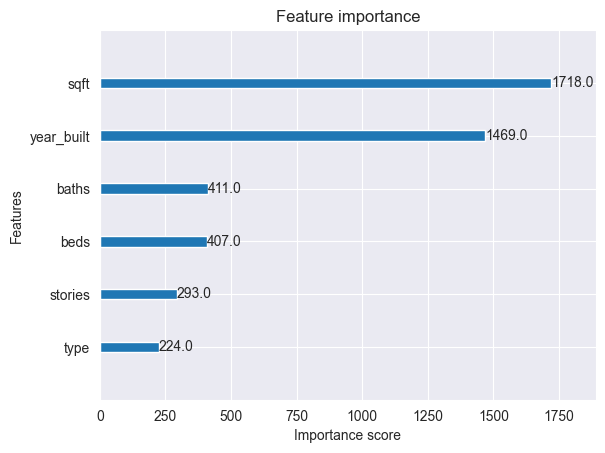

Top features: [('baths', np.float32(0.33190414)), ('sqft', np.float32(0.21852696)), ('stories', np.float32(0.14182174)), ('beds', np.float32(0.10841613)), ('year_built', np.float32(0.1047976)), ('type', np.float32(0.09453343))]


In [89]:
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

X = df_final.drop(columns=['listPrice'])
y = df_final['listPrice']

model = XGBRegressor()
model.fit(X, y)

#  feature importances plot
xgb.plot_importance(model)
plt.show()

# Get top features
importances = model.feature_importances_
feature_names = X.columns
top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
print("Top features:", top_features)

#### Pearson Correlation

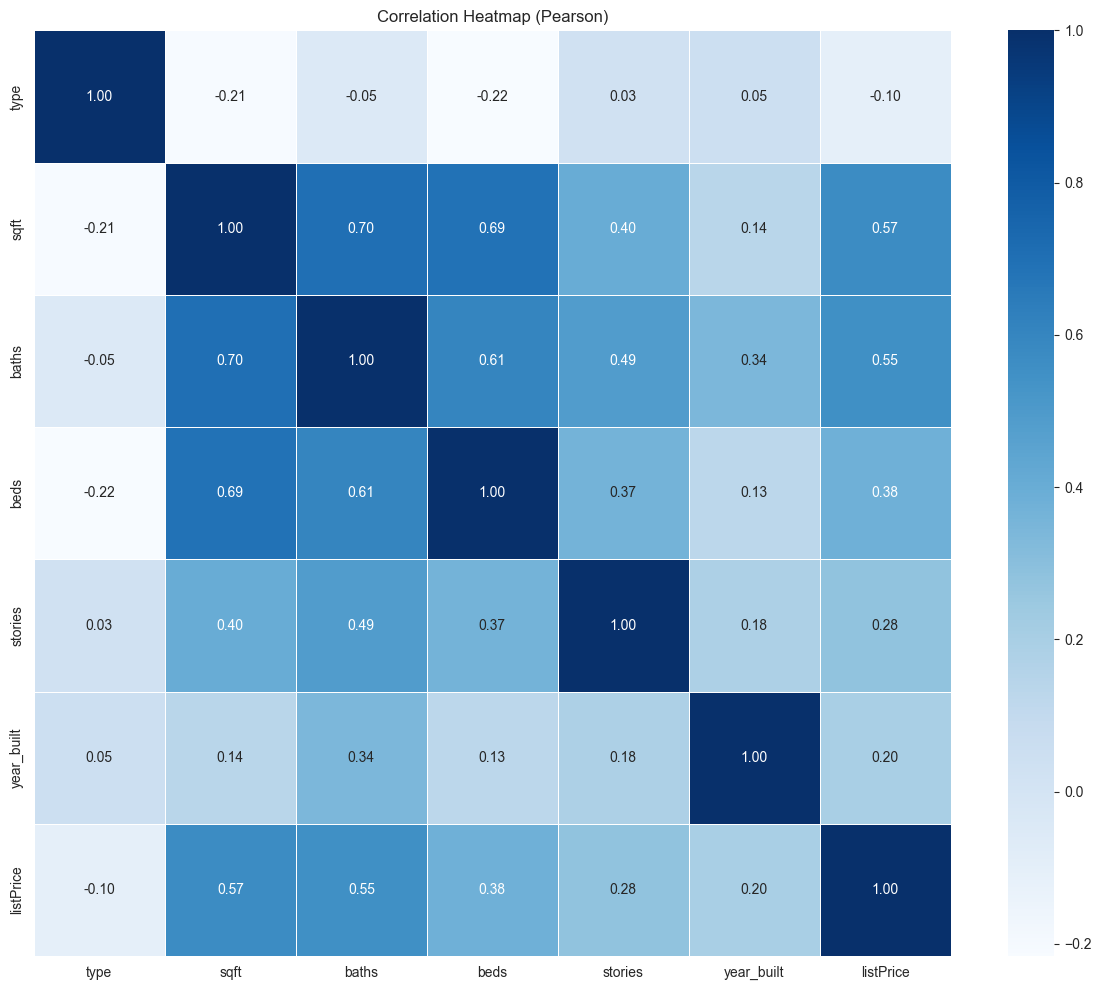

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_final.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Pearson)')
plt.tight_layout()
plt.show()

#### Select the features that are in the top N of both XGBoost importance and Pearson correlation with 'listPrice'

In [114]:

N = 5  # Number of top features to select

# XGBoost feature importance
xgb_model = XGBRegressor()
xgb_model.fit(X, y)
xgb_top = [f for f, _ in sorted(zip(X.columns, xgb_model.feature_importances_), key=lambda x: x[1], reverse=True)[:N]]

# Pearson correlation
corr_matrix = df_no_outliers.corr(numeric_only=True)
price_corr = corr_matrix['listPrice'].drop('listPrice')
corr_top = price_corr.abs().sort_values(ascending=False).index[:N].tolist()

# Intersection
selected_features = list(set(xgb_top) & set(corr_top))
print("Selected features:", selected_features)

Selected features: ['sqft', 'stories', 'baths', 'year_built', 'beds']


###  With All the Features

#### Hyperparameter Tuning using GridSearchCV and Cross Validation with All Features

In [99]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

X_train=df_final.drop(columns=['listPrice'])
y_train=df_final['listPrice']

param_grid = {
    'n_estimators': [100, 300, 500, 700,900],
    'max_depth': [ 5, 7, 9, 11],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9 ]
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    verbose=1,
    n_jobs=-1,
    refit='neg_mean_squared_error'  # refit using the best RMSE
)

grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)
print("Best MAE:", -grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_])
print("Best R²:", grid_search.cv_results_['mean_test_r2'][grid_search.best_index_])

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


KeyboardInterrupt: 

#### Model Training and Evaluation with All Features

In [115]:

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Features and target
X = df_final.drop(columns=['listPrice'])
y = df_final['listPrice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(
    n_estimators=700,
    max_depth=11,
    learning_rate=0.03,
    subsample=0.1,
    colsample_bytree=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 232557.80
MAE: 149952.62
R²: 0.3228


### With Selected Features

#### Hyperparameter Tuning using GridSearchCV with Selected Features

In [112]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Use selected_features from previous feature selection
X_train = df_final[selected_features]
y_train = df_final['listPrice']

param_grid = {
    'n_estimators': [50, 100, 300, 500, 700, 900],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    verbose=1,
    n_jobs=-1,
    refit='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)
print("Best MAE:", -grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_])
print("Best R²:", grid_search.cv_results_['mean_test_r2'][grid_search.best_index_])

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


KeyboardInterrupt: 

#### Model Training and Evaluation with Selected Features

In [116]:
# Model Training and Evaluation with Selected Features using XGBoost

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use selected_features from previous feature selection step
X_selected = df_final[selected_features]
y = df_final['listPrice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(
    n_estimators=700,
    max_depth=11,
    learning_rate=0.03,
    subsample=0.1,
    colsample_bytree=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 232171.97
MAE: 150391.16
R²: 0.3251


In [44]:
# Calculate average price
average_price = df['listPrice'].mean()
print(f"Average Price: ${average_price:.2f}")

Average Price: $507546.54


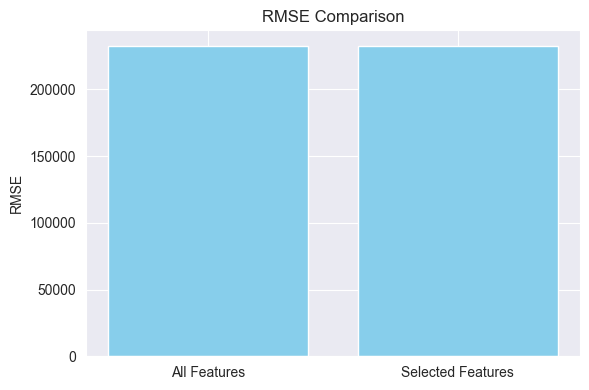

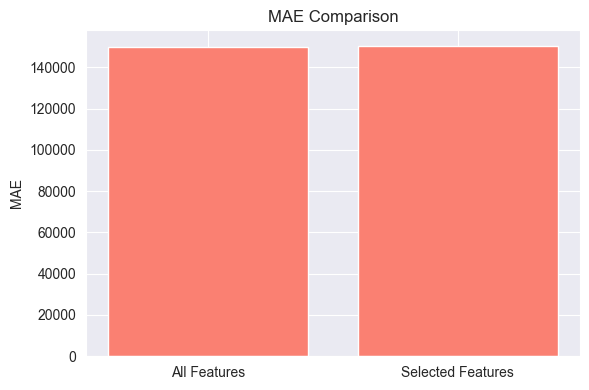

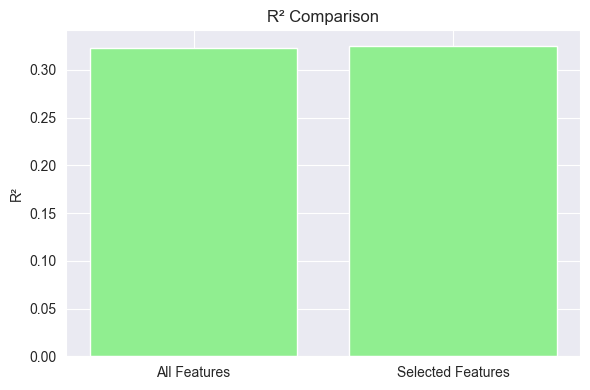

In [117]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    'All Features': {'RMSE': 232557.80, 'MAE': 149952.62, 'R2': 0.3228},
    'Selected Features': {'RMSE': 232171.97, 'MAE': 150391.16, 'R2': 0.3251}
}


labels = list(metrics.keys())
rmse = [metrics[label]['RMSE'] for label in labels]
mae = [metrics[label]['MAE'] for label in labels]
r2 = [metrics[label]['R2'] for label in labels]

x = np.arange(len(labels))

# RMSE graph
plt.figure(figsize=(6,4))
plt.bar(labels, rmse, color='skyblue')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.tight_layout()
plt.show()

# MAE graph
plt.figure(figsize=(6,4))
plt.bar(labels, mae, color='salmon')
plt.ylabel('MAE')
plt.title('MAE Comparison')
plt.tight_layout()
plt.show()

# R² graph
plt.figure(figsize=(6,4))
plt.bar(labels, r2, color='lightgreen')
plt.ylabel('R²')
plt.title('R² Comparison')
plt.tight_layout()
plt.show()